## We will use this workflow to investigate catagorical supervised machine learning for our behavioral annotations.
## The goal is to achieve maximal classification in each decision category. Any means may be used (we care about predictive accuracy). 

In [1]:
# Required Files

# tkd16.pkl # 3d reconstructed coords and the weighted probabilties from DLC
# experimental_data.pickle

# TBD: tkd14.pkl. tkd1.pkl

# optional: ml_array_RM16.h5, kinematic_data_save_df_RM14.h5

In [2]:
import pickle
from Analysis_Utils import preprocessing_df as preprocessing
from Analysis_Utils import query_df
import DataStream_Vis_Utils as utils
import Classification_Utils as CU
import pandas as pd
import pdb
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Classification_Visualization import visualize_models
import numpy as np
import h5py
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Ignore ipython warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib qt
%matplotlib inline

No handles with labels found to put in legend.


In [3]:
# Load dfs

# read kinematics data
d = CU.pkl_to_df('tkd16.pkl')
display(d.head())


# read robot experimental data 
hdf = pd.read_pickle('experimental_data.pickle')
hdf = hdf.reset_index(drop=True)
display(hdf.head())

bodyparts                                                            Handle  \
coords                                                                    X   
rat  date    session dim                                                      
RM16 0190926 S2      0    [-0.04258333327243361, -0.03745508730295129, -...   
             S1      0    [-0.019504937834479028, -0.04189497006852114, ...   
             S4      0    [-0.02860749645471538, -0.03050916325903343, -...   
             S3      0    [-0.004829569816196267, -0.047710999182899054,...   
     0190928 S2      0    [-0.01840026612842802, -0.041214921561555734, ...   

bodyparts                                                                    \
coords                                                                    Y   
rat  date    session dim                                                      
RM16 0190926 S2      0    [-0.051124542875113206, -0.046391097144989096,...   
             S1      0    [-0.029593823214183718, -0.051259080166279856,...   
             S4      0    [-0.038377809181823125, -0.03998369511599506, ...   
             S3      0    [-0.01588439570152417, -0.056160967840578356, ...   
     0190928 S2      0    [-0.0297656858917822, -0.05080324662994153, -0...   

bodyparts                                                                    \
coords                                                                    Z   
rat  date    session dim                                                      
RM16 0190926 S2      0    [-0.047224675501768065, -0.04066595060841428, ...   
             S1      0    [-0.02401885890108034, -0.04726872714890846, -...   
             S4      0    [-0.031403126595622964, -0.03939725201331501, ...   
             S3      0    [-0.009428429887757096, -0.05007730890460198, ...   
     0190928 S2      0    [-0.028303135595699795, -0.04592082214302275, ...   

bodyparts                                                                    \
coords                                                              prob_c1   
rat  date    session dim                                                      
RM16 0190926 S2      0    [-0.04698834692717424, -0.04867294139736495, -...   
             S1      0    [-0.029455692038340094, -0.05137061611873936, ...   
             S4      0    [-0.03085396690780797, -0.03966232079686431, -...   
             S3      0    [-0.01570901191785013, -0.051396684444517164, ...   
     0190928 S2      0    [-0.03038298129872263, -0.04569197836363265, -...   

bodyparts                                                                    \
coords                                                              prob_c2   
rat  date    session dim                                                      
RM16 0190926 S2      0    [-0.046235944961103455, -0.03622334694716918, ...   
             S1      0    [-0.02100924634535533, -0.041638517661544965, ...   
             S4      0    [-0.039060914371074305, -0.032565706104539245,...   
             S3      0    [-0.009872516661810906, -0.04744859882663959, ...   
     0190928 S2      0    [-0.021669111150038046, -0.0397917627969772, -...   

bodyparts                                                                    \
coords                                                              prob_c3   
rat  date    session dim                                                      
RM16 0190926 S2      0    [-0.04191613086350278, -0.0391492133333317, -0...   
             S1      0    [-0.01990704804048865, -0.04176901556711663, -...   
             S4      0    [-0.03203828785113858, -0.030886752805000982, ...   
             S3      0    [-0.010690809214308861, -0.04707722791854087, ...   
     0190928 S2      0    [-0.02475114609532594, -0.040099027045228046, ...   

bodyparts                                                          B Handle  \
coords                                                                    X   
rat  date    session dim                    

,rat,S,Date,dim,time,SF,t_m,lick,x_p,y_p,...,RW,r_start,r_stop,r,t2,t1,exp_response,x_pot,y_pot,z_pot
0,RM9,S2,190918_,/home/pns/rat_reaching/scripts/9pt_pidiv3_cone...,"[20.859866697184316, 20.8858667200725, 20.9028...","[2, 3, 4, 5, 6, 7, 8, 9, 13, 17, 19, 20, 21, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 35.6913, 35.6982, 36.564233333333334, 10...",655.4 916.8 916.8 655.4 655.4 655.4 916.8 655....,794.8 648.8 648.8 449.0 794.8 794.8 648.8 794....,...,0 0 1 0 2 0 3 0 4 ...,"[1513, 6563, 12020, 13242, 20341, 21483, 22472...","[2077, 7124, 12612, 13736, 21060, 22046, 23017...",916.8 916.8 655.4 916.8 614.4 614.4 655.4 916....,491.3 571.1 361.6 571.1 531.0 531.0 707.5 491....,648.8 648.8 794.8 648.8 608.0 608.0 794.8 648....,0 s 1 s 2 s 3 s 4 ...,"[9682, 9682, 9690, 9674, 9682, 9690, 9690, 968...","[6897, 6889, 6921, 6809, 6897, 6905, 6921, 688...","[6049, 6065, 6057, 6161, 6049, 6065, 6073, 606..."
1,RM9,S1,190918_,/home/pns/rat_reaching/scripts/20mm.txt,"[20.414766451136302, 20.440766474024485, 20.48...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 179.05716666666666, 179.09396666666666, ...",614.4 614.4 614.4 614.4 614.4 614.4 614.4 614....,608.0 608.0 608.0 608.0 608.0 608.0 608.0 608....,...,0 0 1 0 2 0 3 0 4 ...,"[9864, 11201, 21864, 24920, 26074, 27904, 2992...","[10430, 11766, 22667, 25452, 26535, 28404, 304...",614.4 614.4 614.4 614.4 614.4 614.4 614.4 614....,531.0 531.0 531.0 531.0 531.0 531.0 531.0 531....,608.0 608.0 608.0 608.0 608.0 608.0 608.0 608....,0 s 1 s 2 s 3 s 4 ...,"[6505, 6361, 6433, 6497, 6521, 6481, 6497, 650...","[6529, 6449, 6505, 6513, 6521, 6529, 6425, 652...","[5641, 5649, 5641, 5633, 5641, 5657, 5705, 564..."
2,RM9,S3,190918_,/home/pns/rat_reaching/scripts/9pt_pidiv3_cone...,"[19.026683361943583, 19.089683564122538, 19.10...","[2, 3, 6, 9, 12, 14, 15, 16, 18, 20, 21, 23]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 122.51423333333334, 122.51763333333334, ...",655.4 916.8 916.8 655.4 655.4 655.4 916.8 655....,794.8 648.8 648.8 449.0 794.8 794.8 648.8 794....,...,0 0 1 0 2 0 3 0 4 ...,"[2191, 14018, 17703, 18863, 21270, 31546, 3251...","[2753, 14597, 18205, 19352, 21850, 32097, 3301...",655.4 916.8 916.8 916.8 916.8 655.4 655.4 916....,707.5 571.1 571.1 571.1 491.3 361.6 707.5 491....,449.0 568.6 648.8 648.8 568.6 449.0 794.8 648....,0 s 1 s 2 s 3 s 4 ...,"[9754, 9730, 9746, 9754, 9754, 9754, 9746, 976...","[6001, 5993, 5977, 6001, 5953, 6001, 6001, 601...","[6057, 6065, 6081, 6057, 6097, 6065, 6073, 605..."
3,RM9,S4,190918_,/home/pns/rat_reaching/scripts/9pt_pidiv3_cone...,"[21.447966702906342, 21.479966767756196, 21.52...","[4, 5, 7, 10, 11, 12, 13, 14, 15, 16, 19, 20, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 214.57526666666666, 214.68453333333332, ...",655.4 916.8 916.8 655.4 655.4 655.4 916.8 655....,794.8 648.8 648.8 449.0 794.8 794.8 648.8 794....,...,0 0 1 0 2 0 3 0 4 ...,"[1873, 18701, 19694, 20832, 26812, 32196, 3331...","[2439, 19269, 20261, 21394, 27761, 32686, 3388...",916.8 614.4 655.4 655.4 655.4 916.8 916.8 655....,571.1 531.0 361.6 707.5 361.6 491.3 491.3 361....,648.8 608.0 449.0 794.8 449.0 648.8 648.8 449....,0 s 1 s 2 s 3 s 4 ...,"[6513, 6529, 6489, 6537, 6521, 6337, 6529, 652...","[6465, 6449, 6457, 6457, 6417, 6449, 6457, 645...","[5625, 5625, 5617, 5633, 5641, 5625, 5625, 563..."
4,RM9,S1,190919_,/home/pns/rat_reaching/scripts/9pt_pidiv3_cone...,"[20.34046666857398, 20.412466695276862, 20.439...","[3, 5, 9, 12, 13, 16, 19, 20, 21, 22, 23, 27, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 108.04173333333334, 108.04273333333333, ...",655.4 916.8 916.8 655.4 655.4 655.4 916.8 655....,794.8 648.8 648.8 449.0 794.8 794.8 648.8 794....,...,0 0 1 0 2 0 3 ...,"[2332, 10392, 11884, 13810, 15792, 18687, 2008...","[2898, 10977, 12461, 14321, 16370, 19248, 2064...",655.4 916.8 655.4 655.4 916.8 655.4 916.8 655....,361.6 491.3 707.5 707.5 571.1 

In [4]:
# Possible Unit Tests 

# 1 
#len(unpickled list) == len(d) == 30
#assert(len(d) == 30)

# 2
#display(d.index)
#tempHDF = hdf.set_index(['rat', 'Date', 'S'])
#for i in tempHDF.index:
#    print(i)
# rate,date,session should exist in both d and tempHDF



In [22]:
# other

d14=pd.read_hdf('kinematic_data_save_df_RM14.h5')
dd_1 = utils.get_single_trial(hdf,'20','S4','RM15')
dd_1 = dd_1.reset_index(drop=True)

display(dd_1['SF'].values)

display(d.index.levels)

hot_vectornl15, ttnl15, featsnl15, enl15 = CU.make_s_f_trial_arrays_from_block(d14,hdf,et,el,'RM14','26','0190926','S2',9)

et =0
el = 0
hot_vector, tt, feats, e = CU.make_s_f_trial_arrays_from_block(d,hdf,et,el,'RM16','18','0190918','S1',9)

FileNotFoundError: File kinematic_data_save_df_RM14.h5 does not exist

In [5]:
# Manual DLC video labels
# TODO? add isInterupted feature

nl1=[
 [1,0,0,1,1,'l','Tug',0,0],#single left rew tug
 [2,0,0,1,1,'l','Tug',0,0], # single left rew tug
[3,0,0,1,1,'rla','noTug',0,0],# rl assist, 1 , notug, rew
 [4,0,0,1,1,'l','noTug',0,0], #l single rew notug
 [5,0,0,1,2,'l','noTug',0,0], # l 2 rew no tug
 [6,0,0,1,2,'lra','Tug',0,0], # lra 2 rew tug
 [7,0,0,1,4,'lra','noTug',0,0],# lra 4 rew notug
 [8,0,0,1,1,'lra','noTug',0,0], # lra 1 rew notug
 [9,0,0,1,1,'l','Tug',0,0], # l 1 rew tug
 [10,0,0,1,1,'l','Tug',0,0], # l 1 rew tug
 [11,0,0,1,1,'lra','Tug',0,0],# lra 2 rew tug
 [12,0,0,1,3,'lra','Tug',0,0], # lra 3 rew tug
 [13,0,0,1,3,'lra','Tug',0,0],# lra 3 rew tug
 [14,0,0,1,1,'bi','Tug',0,0], # bi 1 rew tug
 [15,0,0,1,1,'l','Tug',0,0], # l 1 rew tug
 [16,0,0,1,1,'l','Tug',0,0], # l 1 rew tug
[17,0,0,1,1,'lra','Tug',0,0], #lra 1 rew tug
 [19,0,0,1,2,'bi','Tug',0,0],# bi 2 rew tug
[20,0,0,1,1,'l','Tug',0,0], # l 1 r t
 [21,0,0,1,1,'bi','Tug',0,0], # bi 1 r t
 [22,0,0,1,1,'l','Tug',0,0], # l 1 r t
 [23,0,0,1,1,'lra','Tug',0,0], # lra 1 r t
 [24,0,0,1,1,'l','Tug',0,0], # l 1 r t
 [25,0,0,1,1,'lra','Tug',0,0], # lr 1 r t 
 [26,0,0,1,1,'l','Tug',0,0], # l 1 r t
 [18, 0, 0,1,1,'lra','Tug',0,0], # lr 1 r t
 [0,0,0,1,2,'rla','Tug',1,0] # rl 2 r t hand switch

]

l18=[
[1,0,0,1,1,'l','noTug',0,0], # l 1 rew notug
[2,0,0,1,3,'l','noTug',0,0], # l 3 rew notug
[4,0,0,1,3,'lr','noTug',1,0], # lr 3 switching rew notug
[5,0,0,1,1,'l','noTug',0,0], # l 1 rew no tug
[6,0,0,1,1,'l','noTug',0,0], # l 1 rew no tug
[7,0,0,1,2,'lra','noTug',0,0], # lr 2 rew notug
[9,0,0,1,1,'l','noTug',0,0], # l 1 rew notug (check b4)
[10,0,0,1,1,'lra','noTug',0,0], # lr 1 rew notug
[12,0,0,1,1,'lr','noTug',0,0], # lr 1 rew notug
[14,0,0,1,1,'lr','Tug',0,0], # lr 1 rew tug
[15,0,0,1,1,'l','noTug',0,0], # l 1 rew notug
[17,0,0,1,1,'lra','noTug',0,0], # lr 1 rew notug
[0,0,0,1,4,'l','noTug',0,0], # l 4 norew notug
[3,0,0,1,4,'lra','noTug',1,0], # lr 4 switching norew notug
[8,0,0,1,11,'lra','noTug',1,0], # lr 11 switching norew notug
[11,0,0,1,7,'l','noTug',0,0], # l 7 norew notug
[13,0,0,1,7,'l','noTug',0,0], # l 7 norew notug
[16,0,0,1,2,'l','noTug',0,0], # l 2 norew notug
[18,0,0,1,6,'l','noTug',0,0]
]

nl2=[
 [1,0,0,1,1,'l','noTug',0,0], # l 1 rew notug
 [2,0,0,1,1,'lra','Tug',0,0], # lr 1 rew tug
 [3,0,0,1,2,'lra','Tug',0,0], # lr 2 rew tug
 [4,0,0,1,1,'lra','Tug',0,0], # lr 1 rew tug
 [5,0,0,1,1,'lra','Tug',0,0], # lr 1 rew tug
 [6,0,0,1,2,'lra','Tug',0,0], # lr 2 rew tug
 [7,0,0,1,1,'lra','Tug',0,0], # lr 1 rew tug
 [8,0,0,1,2,'l','Tug',0,0], # l 2 rew tug
 [9,0,0,1,3,'l','Tug',0,0], # l 3 rew tug
 [10,0,0,1,2,'l','noTug',0,0], # l 2 rew nt
 [11,0,0,1,2,'l','noTug',0,0], # l 2 rew nt
 [12,0,0,1,2,'lra','noTug',0,0], # lr 2 rew nt
 [13,0,0,1,2,'lra','noTug',0,0], # lr 2 rew nt
 [14,0,0,1,1,'l','Tug',0,0], # l 1 rew t
 [15,0,0,1,1,'l','Tug',0,0], # l 1 rew t
 [16,0,0,1,1,'lra','noTug',0,0], # lr 1 rew nt
 [17,0,0,1,1,'l','noTug',0,0], # l 1 rew nt
 [18,0,0,1,2,'l','noTug',0,0], # l 2 rew nt
 [19,0,0,1,1,'l','Tug',0,0], # l 1 rew t
 [20,0,0,1,2,'l','noTug',0,0], # l 2 rew nt
 [21,0,0,1,1,'lra','Tug',0,0], # lr 1 rew t
 [22,0,0,1,1,'lra','Tug',0,0], # lr 1 rew t
 [23,0,0,1,1,'l','Tug',0,0], # l 1 rew t
 [24,0,0,1,1,'l','Tug',0,0], # l 1 rew t
 [25,0,0,1,1,'l','Tug',0,0], # l 1 rew t
 [26,0,0,1,1,'l','Tug',0,0], # l 1 rew t
 [27,0,0,1,1,'l','Tug',0,0], # lr 1 rew t
 [28,0,0,1,6,'lra','noTug',1,0], # lr 6 handswitch rew nt
 [30,0,0,1,15,'lra','Tug',0,0], # lr 15 rew t
 [31,0,0,1,1,'l','Tug',0,0], # l 1 rew t
 [32,0,0,1,1,'l','noTug',0,0], # l 1 rew nt
 [33,0,0,1,1,'lra','noTug',0,0], # lr 1 rew nt
 [34,0,0,1,3,'l','Tug',0,0], # l 3 rew t
 [35,0,0,1,1,'l','Tug',0,0], # l 1 rew t
 [36,0,0,1,3,'l','Tug',0,0], # l 3 rew t
 [0,0,0,1,1,'lra','Tug',0,0], # lr 1 rew t
 [29,0,0,1,3,'l','noTug',0,0], # l 3 nr nt
 [37,0,0,1,1,'l','Tug',0,0], # l 1 r t
]

blist1=[
[1,1,1,4,1, 'l', 'Tug', 0,0] # succ tugg, left hand, single reach, 
,[2,1,1,3,1,'l','noTug',0,0 ] # left handed reach, no tug of war, 1 reach, no switch, 
,[3,1,1,3,2,'bi',0,1,0]
,[4,1,1,4,1,'l','Tug',0,0] # tries to grab handle when moving
,[6,1,1,3,1,'l','Tug',0,0] # reaching after handle moves but can't grasp
,[7,1,1,2,2,'l',0,0,0] # A mis-label!!
,[8,1,1,3,1,'l','noTug',0,0]
,[10,1,1,3,2,'l','Tug',0,0]
,[17,1,1,4,1,'l','Tug',0,0] # 
,[18,1,1,3,2,'lbi', 'noTug',1,0] # added lbi for multiple reaching arms
,[19,1,1,3,2,'lbi','noTug',1,0] # lbi
,[20,1,1,4,3,'l','Tug',0,0]
,[21,1,1,4,2,'lbi','Tug',0,0]
,[22,1,1,3,1,'l','noTug',0,0]
,[23,1,1,3,1,'l','noTug',0,0]
,[24,1,1,3,2,'lbi','noTug',0,0]
,[25,1,1,2,4,'l',0,0,0]
,[26,1,1,3,3,'lbi','noTug',1,0]
,[27,1,1,4,1,'lbi','Tug',0,0]
,[28,1,1,3,2,'l','noTug',0,0]
,[30,1,1,3,2,'l','noTug',0,0]
,[31,1,1,3,2,'lbi','noTug',0,0]
,[32,1,1,2,4,'l',0,0,0]
,[33,1,1,4,2,'lr','noTug',1,0]
,[34,1,1,3,1,'lbi','noTug',0,0]
,[35,1,1,3,1,'l','noTug',0,0]
,[37,1,1,4,1,'lbi','Tug',0,0]
,[38,1,1,3,2,'lbi','noTug',0,0]
,[39,1,1,3,3,'l','noTug',0,0]
,[40,1,1,3,1,'l','noTug',0,0]
,[43,1,1,3,1,'bi','noTug',0,0]
,[44,1,1,4,2,'lbi','Tug',0,0]
,[45,1,1,3,1,'lbi','noTug',0,0]
,[46,1,1,3,1,'lbi','noTug',0,0]
,[47,1,1,3,1,'lbi','noTug',0,0]
,[48,1,1,3,2,'lbi','Tug',0,0]
,[0,1,1,0,0,0,0,0,0]
,[5,1,1,2,4,'lr',0,0,0]
,[9,1,1,1,3,'l',0,0,0]
,[11,1,1,1,1,'l',0,0,0]
,[12,1,1,1,1,'l',0,0,0]
,[13,1,1,1,1,'l',0,0,0]
,[14,1,1,1,1,'l',0,0,0]
,[15,1,1,1,1,'l',0,0,0]
,[16,1,1,0,0,0,0,0,0]
,[29,1,1,1,4,'l',0,0,0]
,[36,1,1,1,9,'llr','Tug',1,0] # lots of stuff going on here
,[41,1,1,1,6,'l',0,0,0]
,[42,1,1,1,8,'llr','Tug',1,0]
,[49,1,1,2,4,'lr',0,0,0]]

elist = [
 [0, 1723, 2284, 0, 0, 0, 'no_tug', 0, 30] # null
, [1, 5593, 6156, 0, 0, 0, 'no_tug', 0, 27] # null
, [2, 7866, 8441, 3, 2, 'l', 'no_tug', 0, 14] # success
, [3, 8873, 9426, 1, 7, 'l', 'no_tug', 0, 20] # failed
,[4, 10101, 10665, 1, 3, 'l', 'no_tug', 0, 15] # failed
, [5, 12962, 13524, 1, 8, 'l', 'no_tug', 0, 27] # failed

, [6, 14760, 15351, 3, 2, 'bi', 'no_tug', 1, 25] # success ## bi # starts mid reach 
, [7, 15802, 16431, 3, 3, 'bi', 'no_tug', 1, 30] # success ## bi # starts mid reach # post reaching activity 
,[8, 17400, 17964, 1, 3, 'l', 'no_tug', 0, 13] # failed # starts mid reach 
, [9, 18923, 19485, 3, 4, 'l', 'no_tug', 0, 19] # success
, [10, 20044, 20604, 1, 5, 'l', 'no_tug', 0, 6] # failed
, [11, 24406, 24969, 1, 1, 'l', 'no_tug', 0, 6] # failed # ends mid reach
, [12, 26962, 27521, 3, 1, 'l', 'no_tug', 0, 5] # success # starts mid reach
, [13, 27980, 28536, 1, 12, 'l', 'no_tug', 0, 18] # failed # ends mid reach # lots of reaches
, [14, 29034, 29596, 3, 6, 'bi', 'no_tug', 1, 13] # success ## bi 
, [15, 30106, 30665, 3, 1, 'l', 'no_tug', 0, 8] # success # starts mid reach
, [16, 38998, 39591, 1, 2, 'l', 'no_tug', 0, 4] # failed 
,[17, 40033, 40594, 0, 0, 0, 'no_tug', 0, 32] # null
, [18, 45355, 45914, 3, 7, 'l', 'no_tug', 0, 6] # success 
,[19, 46845, 47405, 3, 1, 'l', 'no_tug', 0, 7] # success

,[20, 50359, 50949, 3, 1, 'l', 'no_tug', 1, 8] # success # post reaching activity with r
, [21, 58229, 58793, 3, 2, 'l', 'tug', 1, 12] # success # post reaching activity with r # rat lets handle go before in reward zone
,[22, 59596, 60427, 3, 2, 'l', 'no_tug', 0, 9] # success 
, [23, 60903, 61466, 3, 1, 'l', 'no_tug', 0, 4] # success
, [24, 62233, 62790, 3, 2, 'l', 'tug', 0, 10] # success # rat lets handle go before in reward zone
, [25, 66026, 66600, 1, 9, 'l', 'no_tug', 0, 27] # classifed as success in py notebook, but is failed trial # ends mid reach
,  [26, 67473, 68046, 3, 1, 'l', 'no_tug', 1, 7] # success # post reaching activity with r
,  [27, 68689, 69260, 3, 2, 'bi', 'no_tug', 1, 9] # success # bi 
,  [28, 70046, 70617, 3, 2, 'bi', 'no_tug', 1, 5] # success # bi # starts mid reach

, [29, 71050, 71622, 3, 11, 'bi', 'tug', 1, 7] # success # bi # starts mid reach # rat lets handle go before in reward zone # lots of reaches
, [30, 72914, 73501, 3, 1, 'l', 'no_tug', 0, 10] # success
, [31, 74777, 75368, 3, 3, 'bi', 'no_tug', 1, 9] # success # bi # post reaching activity with r
, [32, 81538, 82106, 3, 9, 'l', 'no_tug', 1, 13] # success # post reaching activity with r
, [33, 82534, 83114, 3, 4, 'bi', 'tug', 1, 12] # success ## bi # starts mid reach # rat lets handle go before in reward zone # includes uncommon failed bi reach
, [34, 83546, 84118, 3, 2, 'l', 'no_tug', 1, 4] # success # starts mid reach # post reaching activity with r
, [35, 85563, 86134, 3, 2, 'l', 'no_tug', 1, 5] # success # starts mid reach # post reaching activity with r
,[36, 86564, 87134, 1, 13, 'l', 'no_tug', 0, 5] # fail # lots of reaches
, [37, 87574, 88173, 3, 7, 'l', 'no_tug', 1, 8] # success # post reaching activity with r
, [38, 89012, 89584, 3, 4, 'bi', 'tug', 1, 5] # success ## bi # rat lets handle go before in reward zone # includes uncommon reach with r first then left in bi reach

, [39, 90738, 91390, 3, 7, 'l', 'no_tug', 1, 9] # success # post reaching activity with r
, [40, 91818, 92387, 1, 7, 'l', 'no_tug', 0, 6] # fail # starts mid reach
]

In [6]:
# Vectorize DLC labels into ML ready format
# make_vectorized_labels returns list: vectorized list of labels, e: vectorized array of reading indices (unused variables)
elists,ev= CU.make_vectorized_labels(elist)
labellist,edddd= CU.make_vectorized_labels(blist1)
nl1lists,ev1 = CU.make_vectorized_labels(nl1)
nl2lists,ev2 = CU.make_vectorized_labels(nl2)
l18l, ev18 = CU.make_vectorized_labels(l18)

# Define variables
et=0
el=0

# Trialize data
# make_s_f_trial_arrays_from_block args: kinematic df, robot df, 0, 0, rat, date, kdate, session, wv, window_length, pre
    # returns one hot vector, tt1, feature labels, exp features
# windowsize call = 250 atm
hot_vector, tt, feats, e = CU.make_s_f_trial_arrays_from_block(d,hdf,et,el,'RM16','0190920','0190920','S3',9,window_length=250,pre=10)
hot_vector3,tt3,feats3, e3 = CU.make_s_f_trial_arrays_from_block(d,hdf,et,el,'RM16','0190919','0190919','S3',9)# Emily label trial list
hot_vectornl2, ttnl2, featsnl2, enl2 = CU.make_s_f_trial_arrays_from_block(d,hdf,et,el,'RM16','0190917','0190917','S2',9)
hot_vectornl1, ttnl1, featsnl1, enl1 = CU.make_s_f_trial_arrays_from_block(d,hdf,et,el,'RM16','0190917','0190917','S1',9)
hot_vectorl18,ttl18,featsl18, el18 = CU.make_s_f_trial_arrays_from_block(d,hdf,et,el,'RM16','0190918','0190918','S1',9)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mayb

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
maybe an issue?
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mayb

In [7]:
# Match
# match_stampsargs: kin array, label array, exp array
    # returns ml array, ez array
matched_kin_b1, ez1 = CU.match_stamps(tt,blist1,e) # Matched to blist1
matched_kin_e1, ez4 = CU.match_stamps(tt3, elists,e3) # Matched to blist4
matched_kin_b1nl1, eznl1 = CU.match_stamps(ttnl1,nl1lists,enl1) # Matched to blist1
matched_kin_b1nl2, eznl2 = CU.match_stamps(ttnl2,nl2lists,enl2) # Matched to blist1
matched_kin_e1l18, ezl18 = CU.match_stamps(ttl18, l18l,el18) # Matched to blist4

# Slice, reshape, and concat arrays
# create_ML_array args: matched kin array, matched ez array
    # returns ctc
c = CU.create_ML_array(matched_kin_b1,ez1)
c1 = CU.create_ML_array(matched_kin_e1,ez4)
c2 = CU.create_ML_array(matched_kin_e1l18,ezl18)
c3 = CU.create_ML_array(matched_kin_b1nl1,eznl1)
c4 = CU.create_ML_array(matched_kin_b1nl2,eznl2)

# Create final ML arrays
# stack_ML_arrays args: list of k, list of f
    # returns ogk, ogf
final_ML_array,final_feature_array = CU.stack_ML_arrays([c,c1,c2,c3,c4],[blist1,elists,l18l,nl1lists,nl2lists])

display(final_ML_array)
display(final_feature_array)

array([[[-3.27687227e-02, -3.27677808e-02, -3.27671555e-02, ...,
         -1.89881919e-02, -1.89809039e-02, -1.88387673e-02],
        [ 1.20306559e-02,  1.20264022e-02,  1.20181196e-02, ...,
         -2.70457650e-02, -2.70457650e-02, -2.70425216e-02],
        [-2.09163696e-02, -2.11242845e-02, -2.11242845e-02, ...,
         -2.71807518e-02, -2.71867708e-02, -2.71867708e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-1.89788835e-02, -1.89788835e-02, -1.89788835e-02, ...,
          7.16750538e-03,  7.16750538e-03,  7.74807477e-03],
        [ 4.27128123e-02,  4.08022112e-02,  4.08022112e-02, ...,
          1.75470562e-02,  1.75470562e

array([[ 1.,  1.,  1., ...,  1.,  0.,  0.],
       [ 2.,  1.,  1., ...,  0.,  0.,  0.],
       [ 3.,  1.,  1., ...,  1.,  1.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [29.,  0.,  0., ...,  0.,  0.,  0.],
       [37.,  0.,  0., ...,  1.,  0.,  0.]])

In [17]:
# Save final_ML_array and final_feature_array in h5 file

with h5py.File('ml_array_RM16.h5', 'w') as hf:
    hf.create_dataset("RM16",  data=final_ML_array)
    hf.create_dataset("RM16_labels",data=final_feature_array)

In [11]:
# Load final_ML_array and final_feature_array in h5 file

# reference: https://stackoverflow.com/questions/51139899/valueerror-no-dataset-in-hdf5-file-with-pandas-read-hdf-from-a-matlab-h5-file?noredirect=1&lq=1
f = h5py.File('ml_array_RM16.h5', 'r')
final_ML_array = f['RM16'][:]
final_feature_array = f['RM16_labels'][:]

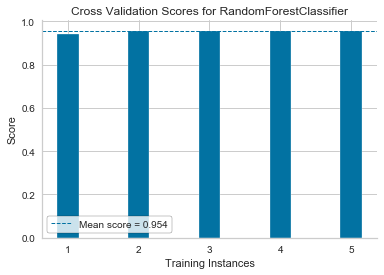

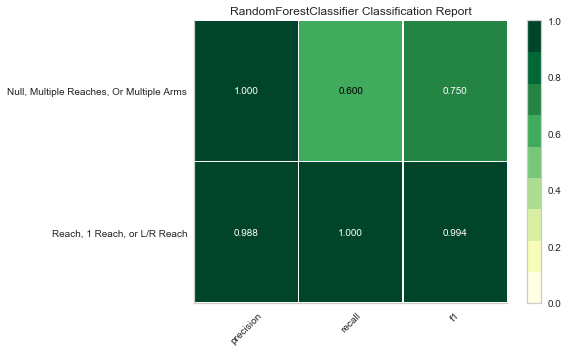

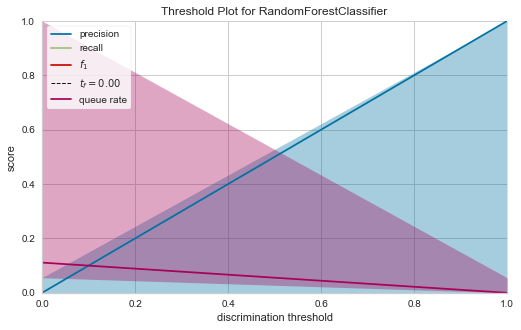

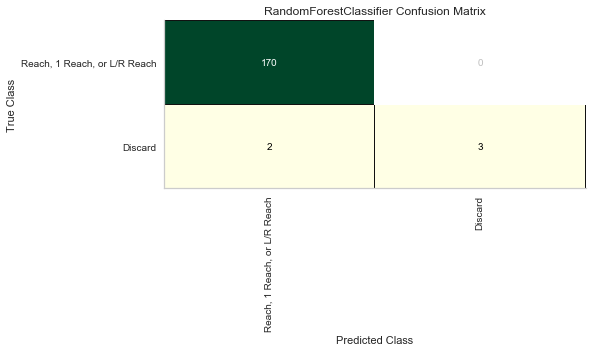

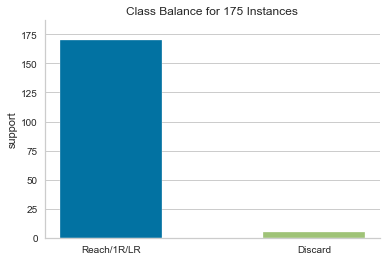

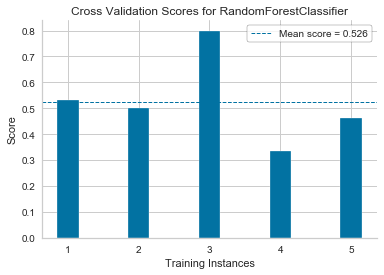

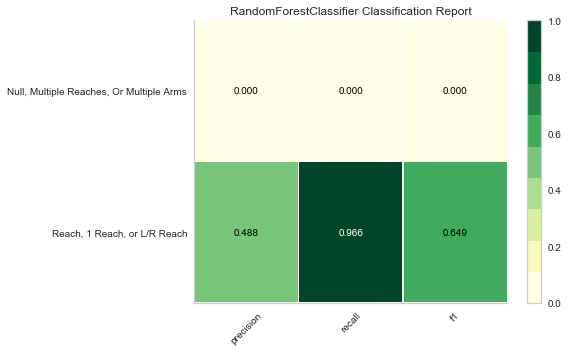

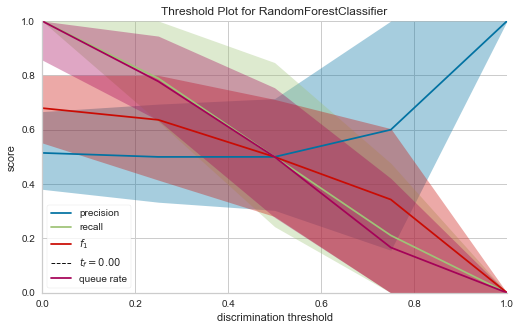

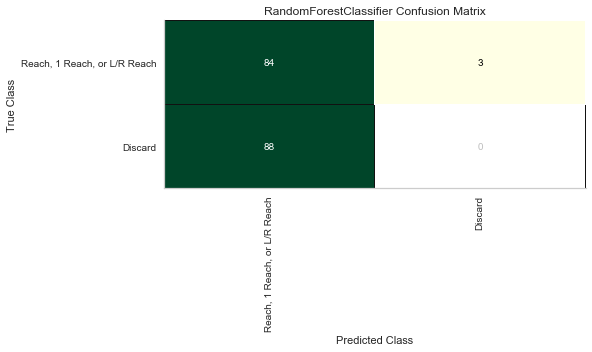

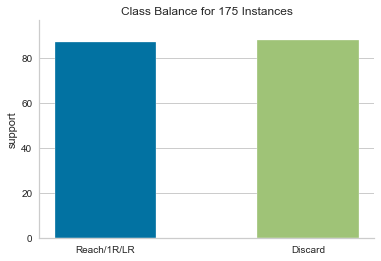

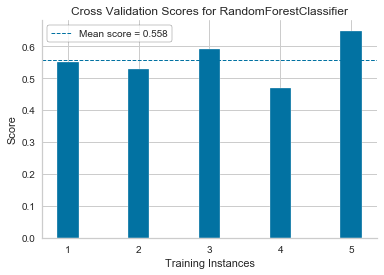

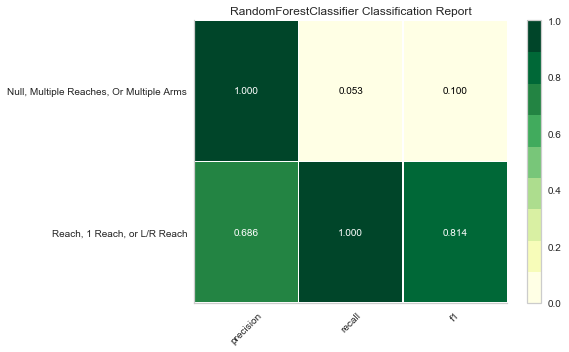

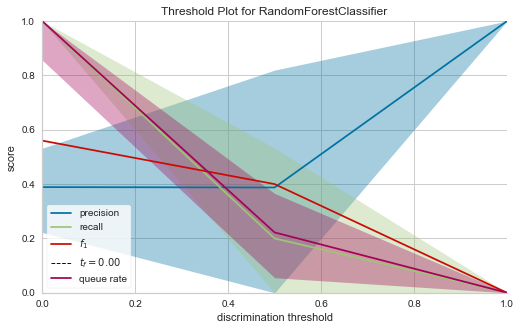

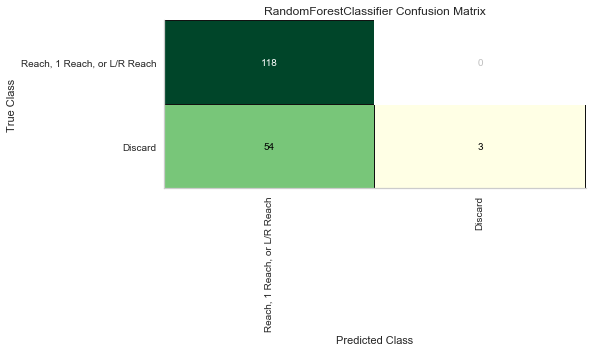

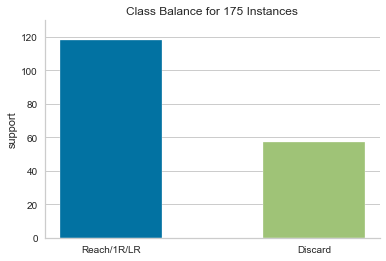

In [8]:
# Run Classification using Random Forest Model with NO PCA

#model = RandomForestClassifier(n_estimators=5000,max_depth=2)
#model = RandomForestClassifier(n_estimators=100,max_depth=2) #default args

model = RandomForestClassifier(n_estimators=2,max_depth=2)
predictions, trained_model = CU.classification_structure(final_ML_array,final_feature_array,model,kFold=5,LOO=False)

# cumulative variance explained -> produce plot for PCA
# LARGE # of PC's!!! 
# Increase WINDOW SIZE!!!!

# Automate pipeline extraction
# Class balances, 
# Classifiers should be run across all data
# Balance Classes

# Heirarchy: N>2? N<2?

# Extend trial by 400 frames , check accuracy!

In [19]:
# Try Plotting Tree. 
# make mini but working


import graphviz 
from sklearn import tree 

dot_data = tree.export_graphviz(trained_model, out_file=None, 
                     feature_names=['a', 'b', 'c'],  
                     class_names=['x', 'y', 'z'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  

ValueError: Length of feature_names, 3 does not match number of features, 82800

In [9]:
# View predictions

display(predictions)
display(trained_model)
#display(classifier_pipeline)



## Function to:: Strip various features, feature sets (do exp vs kinematic) from ML vector, compare

# wow really bad now

# re-sample classes, maybe try to classify "which" arm

# ask how many reaches w/ changepoints?

[array([0.94285714, 0.97142857, 0.97142857, 0.97142857, 0.97142857]),
 array([0.34285714, 0.48571429, 0.51428571, 0.51428571, 0.31428571]),
 array([0.51428571, 0.65714286, 0.74285714, 0.45714286, 0.71428571])]

RandomForestClassifier(max_depth=2, n_estimators=2)

In [ ]:
# Attempt Plot tree...slow?

from sklearn import tree
model = tree.DecisionTreeClassifier()
predictions, trained_model, classfier_pipeline = CU.classification_structure(final_ML_array,final_feature_array,model,kFold=5,LOO=False)


tree.plot_tree(trained_model)

In [12]:
# Run Classification using Random Forest Model with PCA_data
# bug with PCA TODO?

#model = RandomForestClassifier(n_estimators=10000,max_depth=2)
model = RandomForestClassifier(n_estimators=2,max_depth=2)
predictions = CU.classification_structure(final_ML_array,final_feature_array,model,kFold=5,LOO=False,PCA_data=3,bal=False)

TypeError: 'numpy.float64' object is not iterable

In [ ]:


models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=5),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=3000),
    RandomForestClassifier(n_estimators=3000)
]



# start grid-searching over these models w/ diff parameters.
n=3
pred_array=[]
for model in models:
    for ix in range(1,10):
         pred_array.append(CU.classification_structure(final_ML_array,final_feature_array,model,kFold=5,LOO=False,PCA_data=n,bal=False))
            

# Plot predictions inside of pred array 
n=3
nr = np.linspace(0,len(models))
colors = ['r','g','b','m','y','o','gold','silver','peru']
for i,m in enumerate(models):
    m=str(m) # get label name
    pz=pred_array[i]
    ax=plt.figure()
    ax.plot(nr,pz,c=colors[i],label=m)

In [ ]:
# Segmentation

# c is ML vector, tt is kinematics

# take PC's, segment each trial
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import PCA
transformer = SparsePCA(n_components=3, random_state=0)

cxs=transformer.fit_transform(c.reshape(c.shape[0],c.shape[1]*c.shape[2]))

cxs_kin = transformer.fit_transform(tt.reshape(tt.shape[0],tt.shape[1]*tt.shape[2]*tt.shape[3]))

#for idx in range(0,c.shape[0]):


In [ ]:
cxs_kin.shape # compressed entire feature space into vector

In [ ]:
def trialized_PCA(ml_array,n_comps=3,sparse=False):
    if sparse:
        transformer = SparsePCA(n_components=n_comps, random_state=0)
    else:
        transformer=PCA(n_components=n_comps,random_state=0,whiten=True)
    pdb.set_trace()
    num_trials=ml_array.shape[0]
    nfeats=ml_array.shape[1]
    len_trials=ml_array.shape[2]
    pc_array = np.zeros((num_trials,len_trials,n_comps))
    for xii in range(0,num_trials):
        pc_array[xii,:,:] = transformer.fit_transform(ml_array[xii,:,:].reshape(len_trials,nfeats))
    return pc_array

In [ ]:
pcsx = trialized_PCA(c)
pcsx.shape

In [ ]:
# plot pca 1st 10 trials

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
# Plot PCA for diff exp behaviors
#ck = transformer.transform(cxs_kin)

def plot_PCA(X,color='r',handle=0):
    handle = str(handle+'   trial')
    ax.scatter(X[0, 0], X[0, 1], X[0, 2],c=color,s=400,
           edgecolor='k',label='Start')
    ax.scatter(X[-1, 0], X[-1, 1], X[-1, 2],c=color,s=400,
           edgecolor='k',label='End')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2],c=color,
           edgecolor='k',label=handle)
    ax.plot(X[:, 0], X[:, 1], X[:, 2],c=color,
           label=handle)
    plt.legend()
    plt.title('Trial-To-Trial PCA Projection of Feature Vector (Experiment + Posture)')
#plot_PCA(pcsx[2,:,:])

c_list = ['r','g','b','m','k']

for rfx in range(10,15):
    rr=rfx-10
    plot_PCA(pcsx[rfx],c_list[rr],handle=str(rfx))
    